# Fish Species Classification Using VGG16

## Data Loading

In [1]:
# Set up to access Kaggle API

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
# Downloading Dataset via Kaggle

!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.23G/3.24G [00:21<00:00, 164MB/s]
100% 3.24G/3.24G [00:21<00:00, 161MB/s]


In [3]:
# Extracting Data from ZIP File

import zipfile
zip_ref = zipfile.ZipFile('/content/a-large-scale-fish-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Data Preparation

In [4]:
# Importing Necessory Libraries

import os
import glob as gb
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import MobileNetV2,VGG16
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [5]:
df = r'/content/Fish_Dataset/Fish_Dataset'

In [6]:
all_path=[]
for img_path in os.listdir(df):
    if img_path in ['Segmentation_example_script.m','README.txt','license.txt'] :
        continue

    all_data=gb.glob(pathname=df+'/'+img_path+'/'+img_path+'/*.*')
    print(' found {} in {} '.format(len(all_data),img_path))
    all_path.extend(all_data)

 found 1000 in Sea Bass 
 found 1000 in Black Sea Sprat 
 found 1000 in Striped Red Mullet 
 found 1000 in Hourse Mackerel 
 found 1000 in Red Sea Bream 
 found 1000 in Trout 
 found 1000 in Shrimp 
 found 1000 in Red Mullet 
 found 1000 in Gilt-Head Bream 


In [7]:
df=pd.DataFrame({'Filepath':all_path})
df['Label']=df['Filepath'].apply(lambda x :x.split('/')[-2])
pd.options.display.max_colwidth = 200

df = df.sample(frac=1).reset_index(drop = True)
df.head(5)

,Filepath,Label
0,/content/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00704.png,Gilt-Head Bream
1,/content/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00202.png,Gilt-Head Bream
2,/content/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream/00436.png,Red Sea Bream
3,/content/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet/00240.png,Red Mullet
4,/content/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00470.png,Gilt-Head Bream


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  9000 non-null   object
 1   Label     9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [9]:
df.shape

(9000, 2)

## Data Visualization

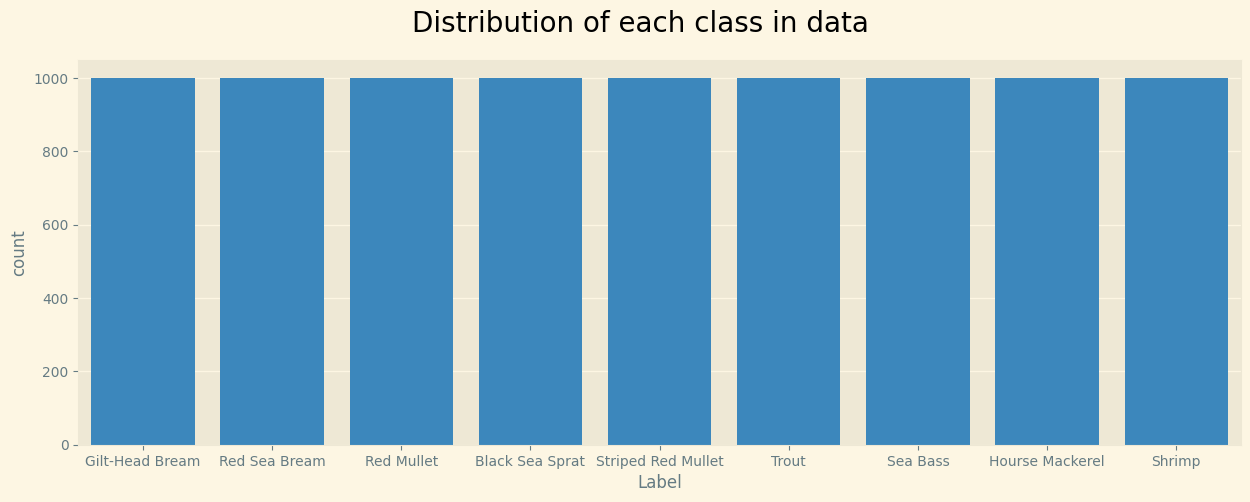

In [10]:
plt.figure(figsize=(15,5))
sns.countplot(data=df,x='Label')
plt.suptitle('Distribution of each class in data',size=20)
plt.show()

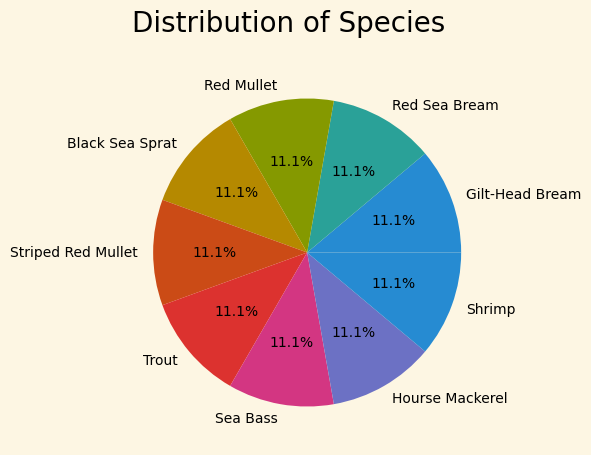

In [11]:
plt.figure(figsize=(15,5))
plt.xticks(rotation = 60)
plt.pie(x=df['Label'].value_counts().values,labels=df['Label'].value_counts().index,autopct='%1.1f%%')
plt.suptitle('Distribution of Species',size=20)
plt.show()

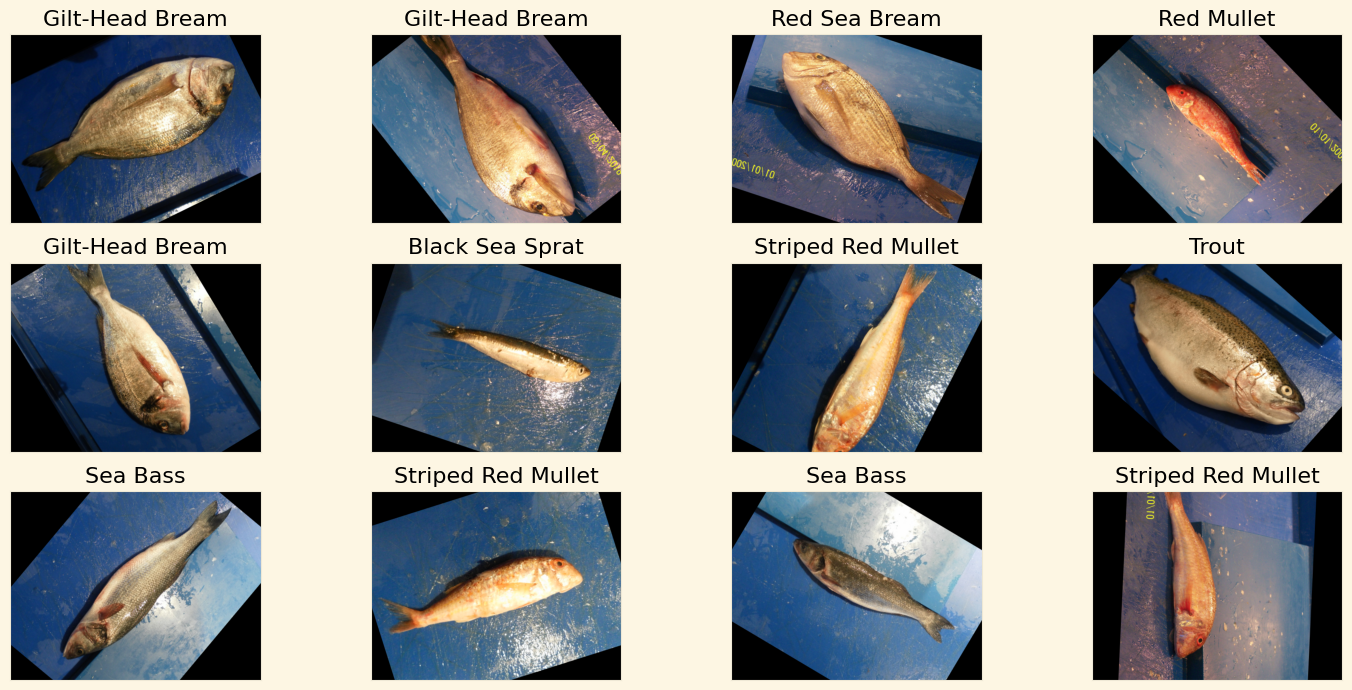

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i])
plt.tight_layout()
plt.show()

## Data Preprocessing

In [13]:
train_df,test_df=train_test_split(df,test_size=0.1,shuffle=True,random_state=1)

In [14]:
print('The dimension of training data :',train_df.shape)
print('The dimension of testing data :',test_df.shape)

The dimension of training data : (8100, 2)
The dimension of testing data : (900, 2)


In [15]:
## Data Augmentation

training_generator=ImageDataGenerator(
                                     tf.keras.applications.vgg16.preprocess_input,
                                      validation_split=0.2,
                                      )

testing_generator=ImageDataGenerator(
                                    tf.keras.applications.vgg16.preprocess_input
                                    )

training_images=training_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'

)


validation_images=training_generator.flow_from_dataframe(

    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'

)

testing_images=testing_generator.flow_from_dataframe(

    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    shuffle=False,
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


## Model Building

In [16]:
epochs=7
batch_size=32

early_stopping=EarlyStopping(monitor='val_loss',patience=3,verbose=1,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=0,factor=0.1)
model_check_point=ModelCheckpoint(monitor='val_accuracy',filepath='./bestmodel.keras',save_best_only=True,verbose=True)

In [17]:
model=VGG16(

    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

model.trainable=False

58889256/58889256 [==============================] - 0s 0us/step


In [18]:
inputs=model.input

x=Dense(128,activation='relu')(model.output)
x=Dense(128,activation='relu')(x)
x=Dropout(rate=0.3)(x)
x=BatchNormalization()(x)
x=Dense(64,activation='relu')(x)

outputs=Dense(9,activation='softmax')(x)

model=Model(inputs=inputs, outputs=outputs)

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
history=model.fit(

    training_images,
    validation_data=validation_images,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping,reduce_lr,model_check_point]

)

## Model Prediction

In [ ]:
history_df=pd.DataFrame(history.history)
history_df

In [ ]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()